#  项目：信用贷款违约预测

# —、项目介绍

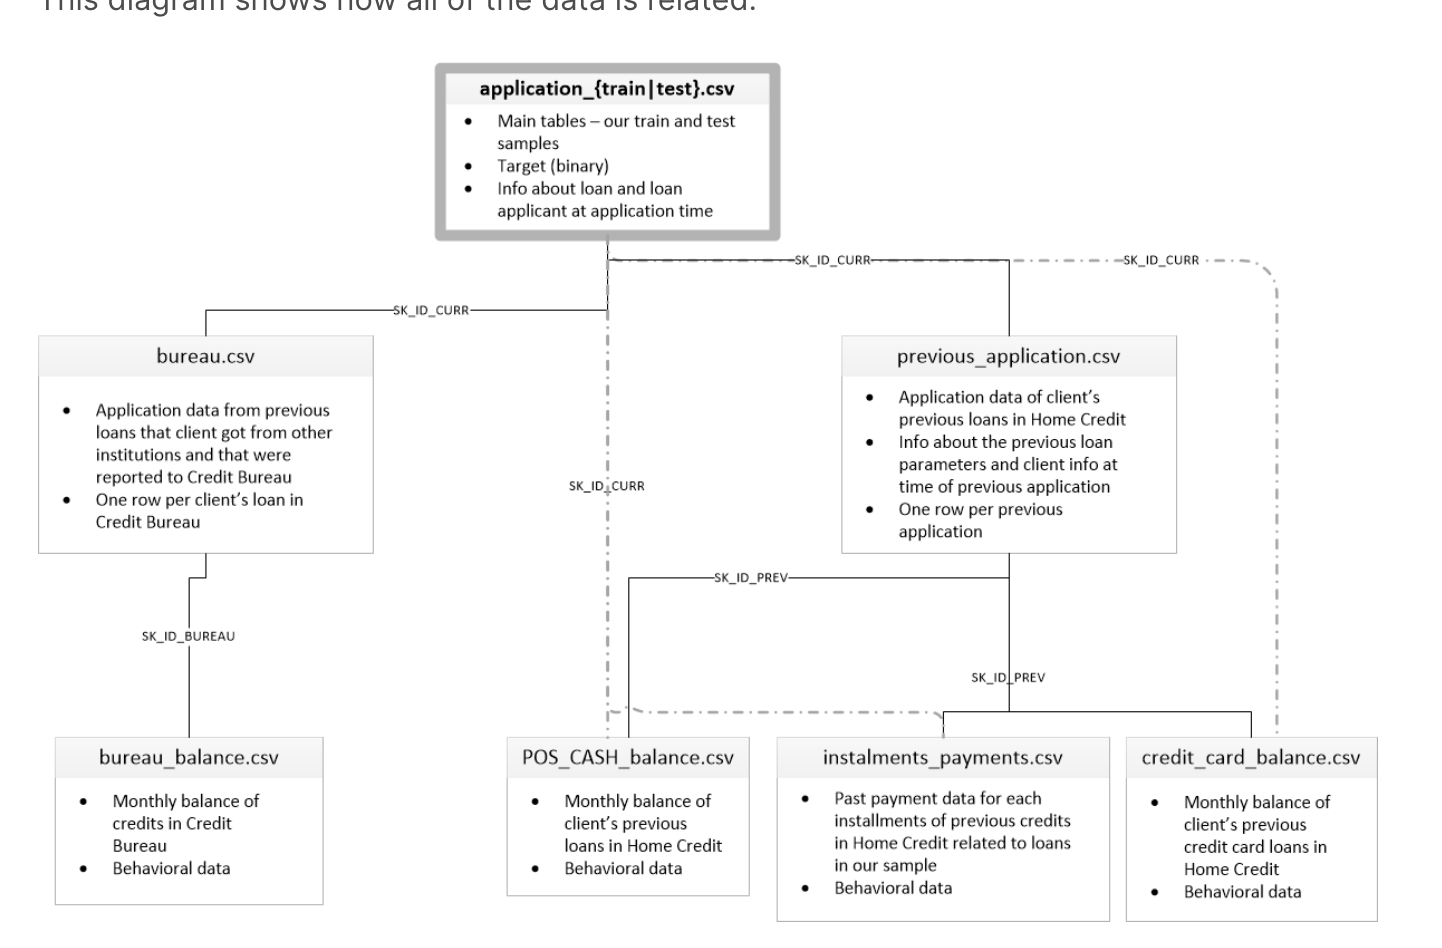


In [1]:
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import pandas as pd
import plotly.offline as offline
offline.init_notebook_mode()
# from plotly import tools
# import plotly.tools as tls
# import squarify
# from mpl_toolkits.basemap import Basemap
# from numpy import array
# from matplotlib import cm

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()
plt.style.use('fivethirtyeight')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
app_train = pd.read_csv('./data/application_train.csv')
app_test = pd.read_csv('./data/application_test.csv')

# 二、主训练集探索

In [3]:
app_train.head() 

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

## 1. 数据探索
首先需要对数据做一些探索，
- 一是了解数据的缺失值情况、异常值情况，以便做对应的数据清洗。
- 二是了解一下违约贷款和正常贷款用户画像的区别，加深对业务的理解，为后面的数据分析（特征工程）展开打基础


### 异常值检测


In [4]:
#定义缺失值检测函数
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

数据一共有122列，有67列存在缺失情况，最高缺失值的列缺失度为69.9%。

可以发现前面的几列特征缺失度的都是一样的，并且它们都是属于房屋信息，根据这个规律可以猜测用户缺失房屋信息可能是因为某种特定原因导致的，而不是随机缺失，这点会在后面的特征工程用上。

In [5]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

### 异常值探索
对主训练集进行一些异常值的探索，采取描述统计的方法，即查看特征的均值、极大值、极小值等信息判断是否有异常值

查看用户年龄的数据分布情况（因为数据中，年龄的数值是负数，反映的是申请贷款前，这个用户活了多少天，所以这里我除了负365做了下处理）,发现数据的分布还是比较正常的，最大年龄69岁，最小年龄20岁，没有很异常的数字

In [7]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

查看用户的工作时间分布情况发现（同样工作时间也是负数，所以我除了负365），最小值是-1000年，这里的-1000年明显是一个异常数据，没有人的工作时间是负数的，这可能是个异常值

In [8]:
(app_train['DAYS_EMPLOYED']/-365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

看一下用户受工作时间的数据分布情况，发现所有的异常值都是一个值，365243，对于这个异常值我的理解是它可能是代表缺失值，所以我的选择是将这个异常值用空值去替换，这样可以保留这个信息，又抹去了异常值，替换之后我们再看一下工作时间的分布情况，正常了很多


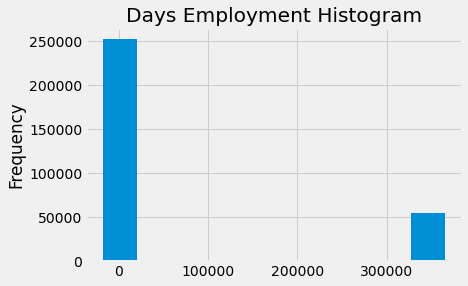

In [51]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');

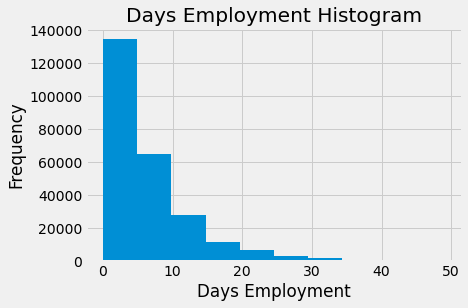

In [52]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
(app_train['DAYS_EMPLOYED']/-365).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

## 违约用户画像探索 

这部分分析的目标主要是查看违约用户和非违约用户的特征分布情况，目标是对违约用户的画像建立一个基本的了解，为后续特征工程打下基础。

In [53]:
#这一段是画图代码，无需弄懂
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();
    
def plot_distribution(var):
    
    i = 0
    t1 = app_train.loc[app_train['TARGET'] != 0]
    t0 = app_train.loc[app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

首先来看一下男性和女性用户的违约率情况，发现男性用户违约率更高，男性用户违约率为10%，女性为7%


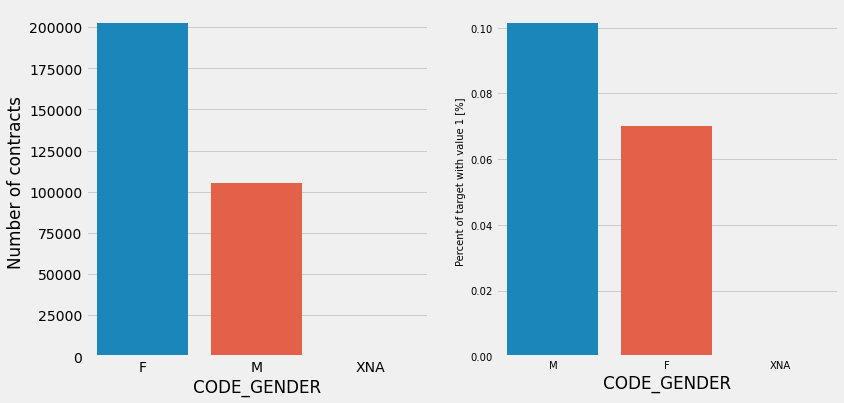

In [54]:
plot_stats('CODE_GENDER')

下面再来看一下违约用户和正常用户的年龄分布情况，因为年龄是连续型变量，所以使用分布图去看年龄的分布情况，通过数据分布可以看到，违约用户年轻用户分布更多，所以可以推断的结论是用户年龄越小，违约的可能性越大

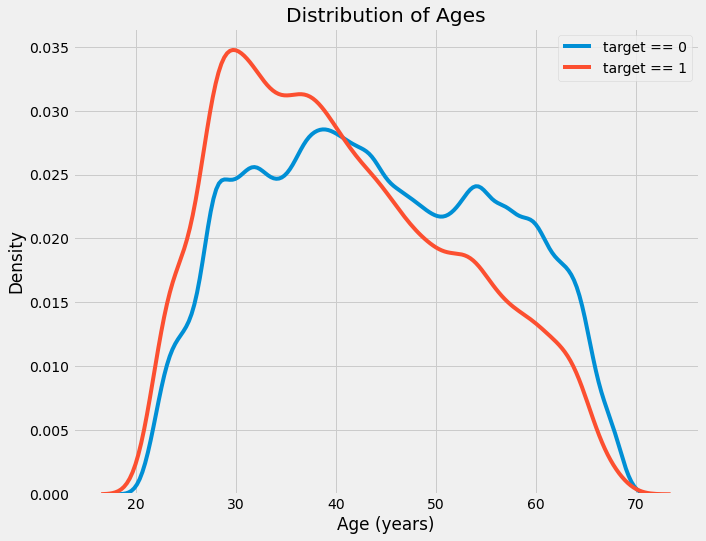

In [55]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend();

可以对用户的年龄进行分捅，进一步观察不同年龄段用户的违约概率，发现确实是用户年龄越小，违约的可能性越高


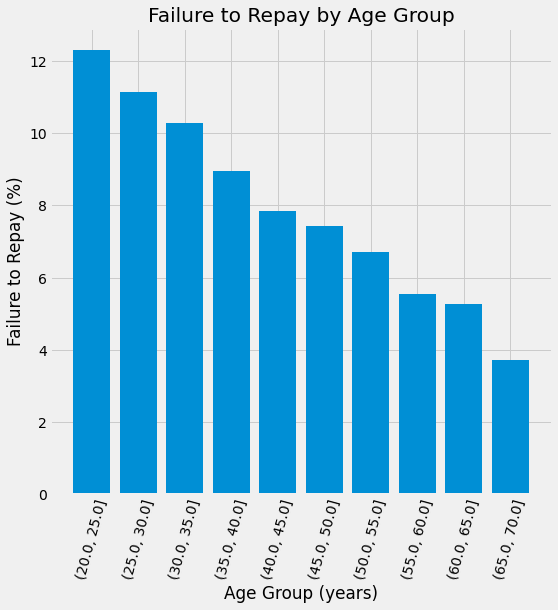

In [56]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_groups  = age_data.groupby('YEARS_BINNED').mean()
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

再来看一下不同贷款类型的违约率情况，对于现金贷款和流动资金循坏贷款，现金贷款的违约率更高


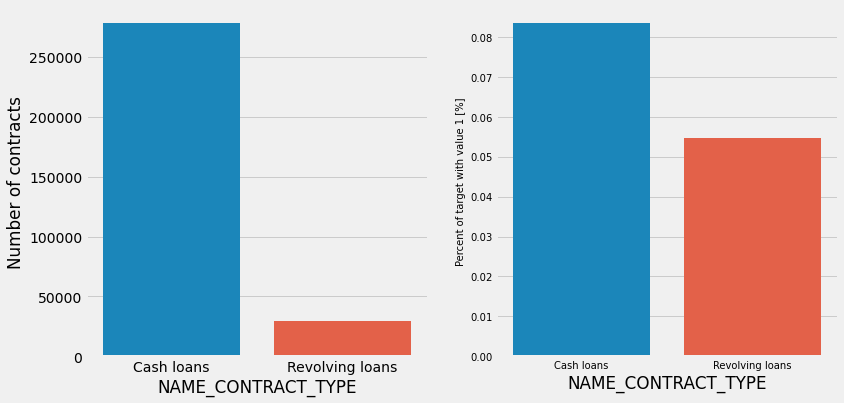

In [57]:
plot_stats('NAME_CONTRACT_TYPE')

看下用户有没有房和车对违约率的影响，发现没有车和房的人违约率更高，但相差并不是很大


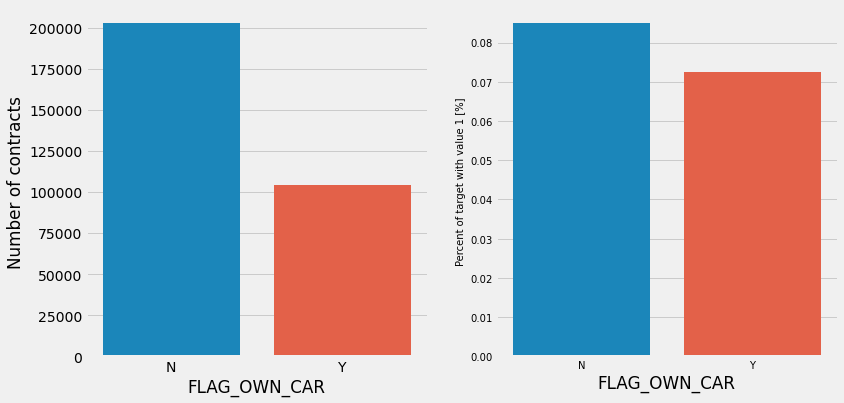

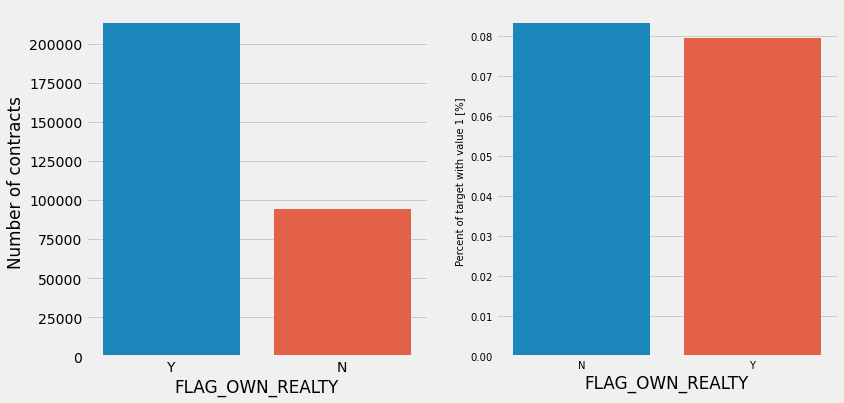

In [58]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

从家庭情况看，申请的用户大多已经结婚，单身和世俗结婚的违约率较高，寡居的违约率最低


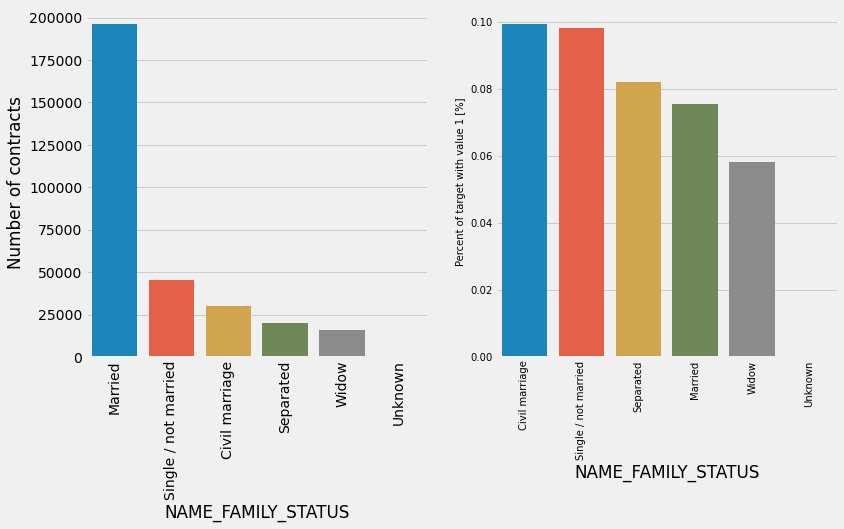

In [59]:
plot_stats('NAME_FAMILY_STATUS',True, True)

看一下子女信息，大部分申请者没有孩子或孩子在3个以下，孩子越多的家庭违约率越高，发现对于有9、11个孩子的家庭违约率达到了100%（和样本少也有关系）

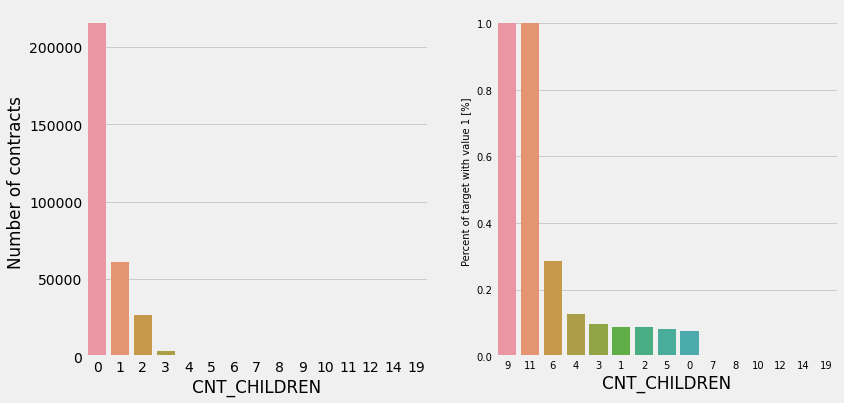

In [60]:
plot_stats('CNT_CHILDREN')

根据申请者的收入类型区分，可以发现休产假和没有工作的人违约率较高，在35%以上，对于这两类人群放款需较为谨慎


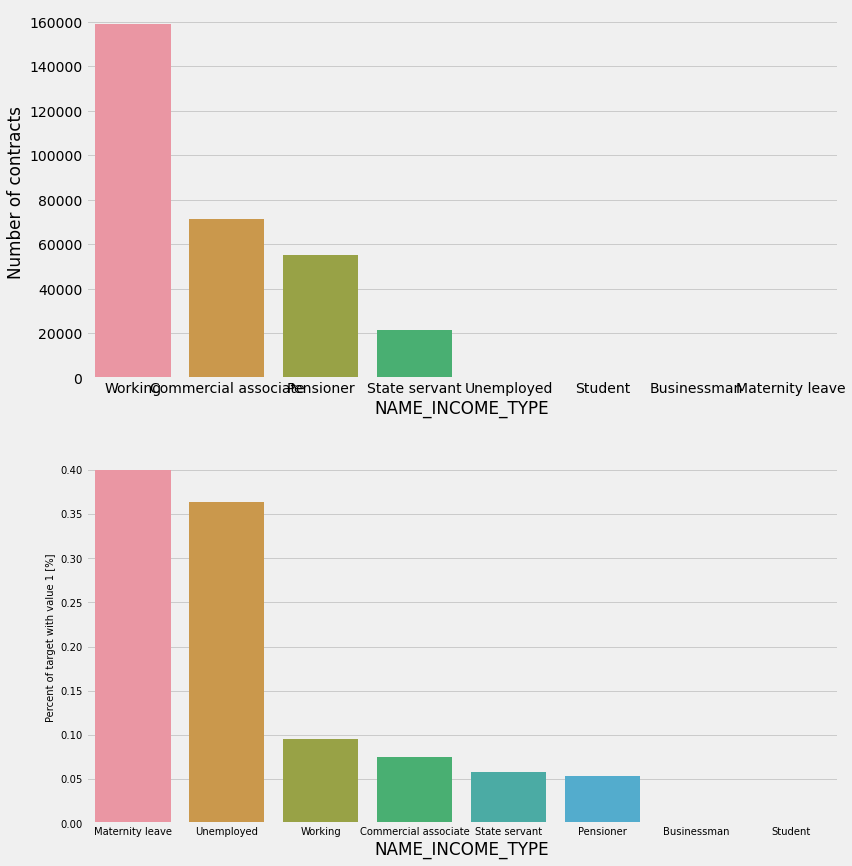

In [61]:
plot_stats('NAME_INCOME_TYPE',False,False)

从职业来看，越相对收入较低、不稳定的职业违约率越高，比如低廉劳动力、司机、理发师，而像会计、高科技员工等具有稳定高收入的职业违约率就较低


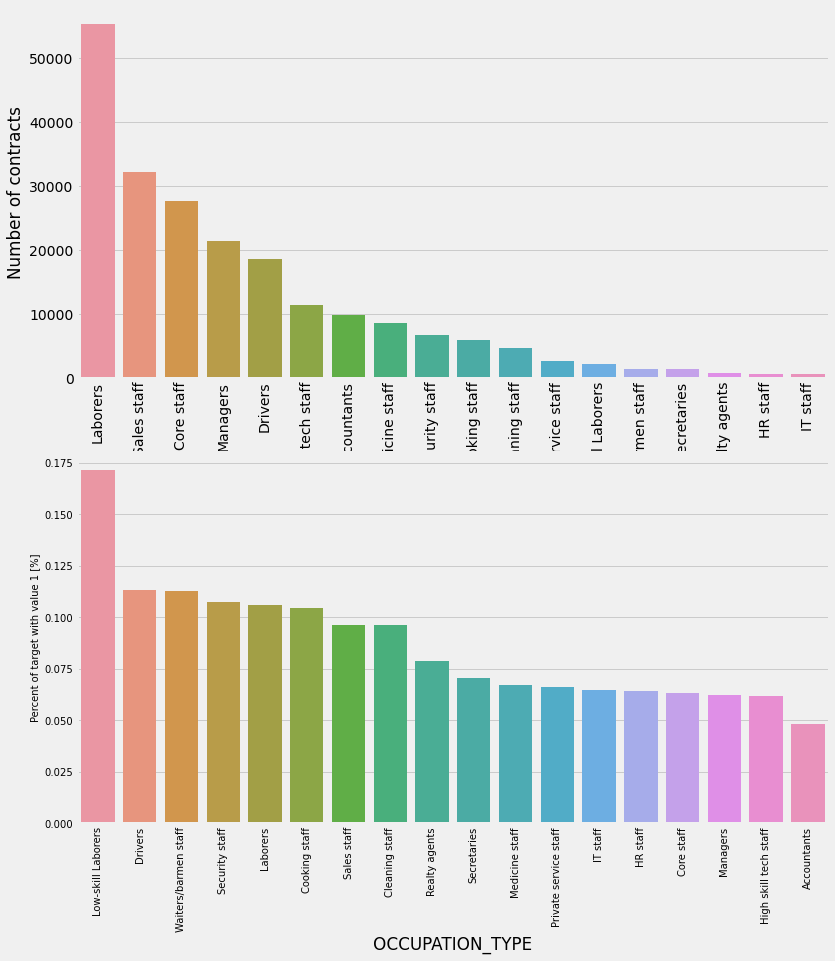

In [62]:
plot_stats('OCCUPATION_TYPE',True, False)

贷款申请人受教育程度大多为中学，学历越低越容易违约


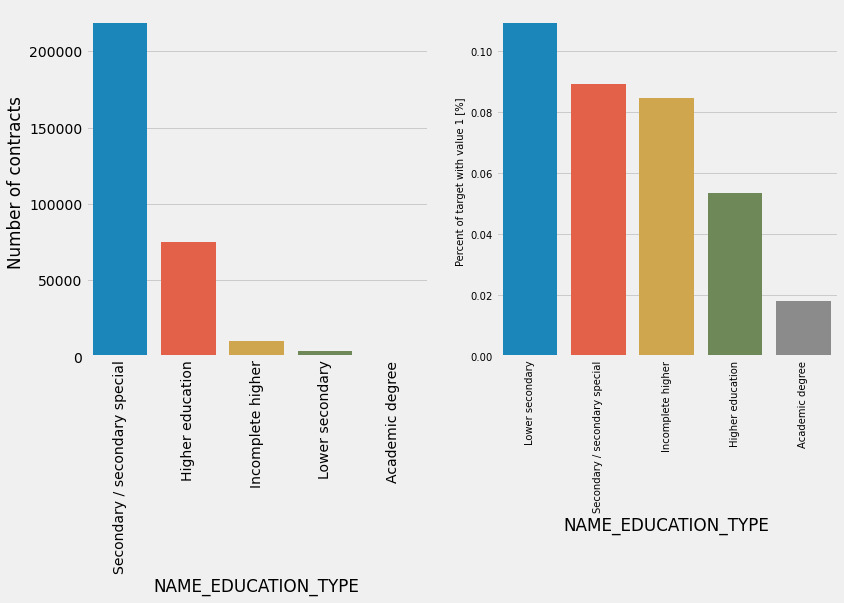

In [63]:
plot_stats('NAME_EDUCATION_TYPE',True)

## 特征工程

接下来通过对特征的一些理解，尝试做出一些新的特征


1. CREDIT_INCOME_PERCENT: 贷款金额/客户收入，预期是这个比值越大，说明贷款金额大于用户的收入，用户违约的可能性就越大

2. ANNUITY_INCOME_PERCENT: 贷款的每年还款金额/客户收入，逻辑与上面一致

3. CREDIT_TERM: 贷款的每年还款金额/贷款金额，贷款的还款周期，猜测还款周期短的贷款，用户的短期压力可能会比较大，违约概率高

4. DAYS_EMPLOYED_PERCENT: 用户工作时间/用户年龄

5. INCOME_PER_CHILD：客户收入/孩子数量，客户的收入平均到每个孩子身上，同样的收入，如果这个人的家庭很大，孩子很多，那么他的负担可能比较重，违约的可能性可能更高

6. HAS_HOUSE_INFORMATION : 这里根据客户是否有缺失房屋信息设计一个二分类特征，如果未缺失的话是1，缺失的是0

In [64]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_train_domain['INCOME_PER_CHILD'] = app_train_domain['AMT_INCOME_TOTAL'] / app_train_domain['CNT_CHILDREN']
app_train_domain['HAS_HOUSE_INFORMATION'] = app_train_domain['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)

对我们设计出来的连续性特征查看它们在违约用户和非违约用户中的分布情况，可以发现除CREDIT_TERM这个特征外，其他的特征区分度似乎都不是很明显，大家不需要灰心，这个是很正常的现象，虽然现在看起来区分度较小，但我们可以放到模型中再看一下效果

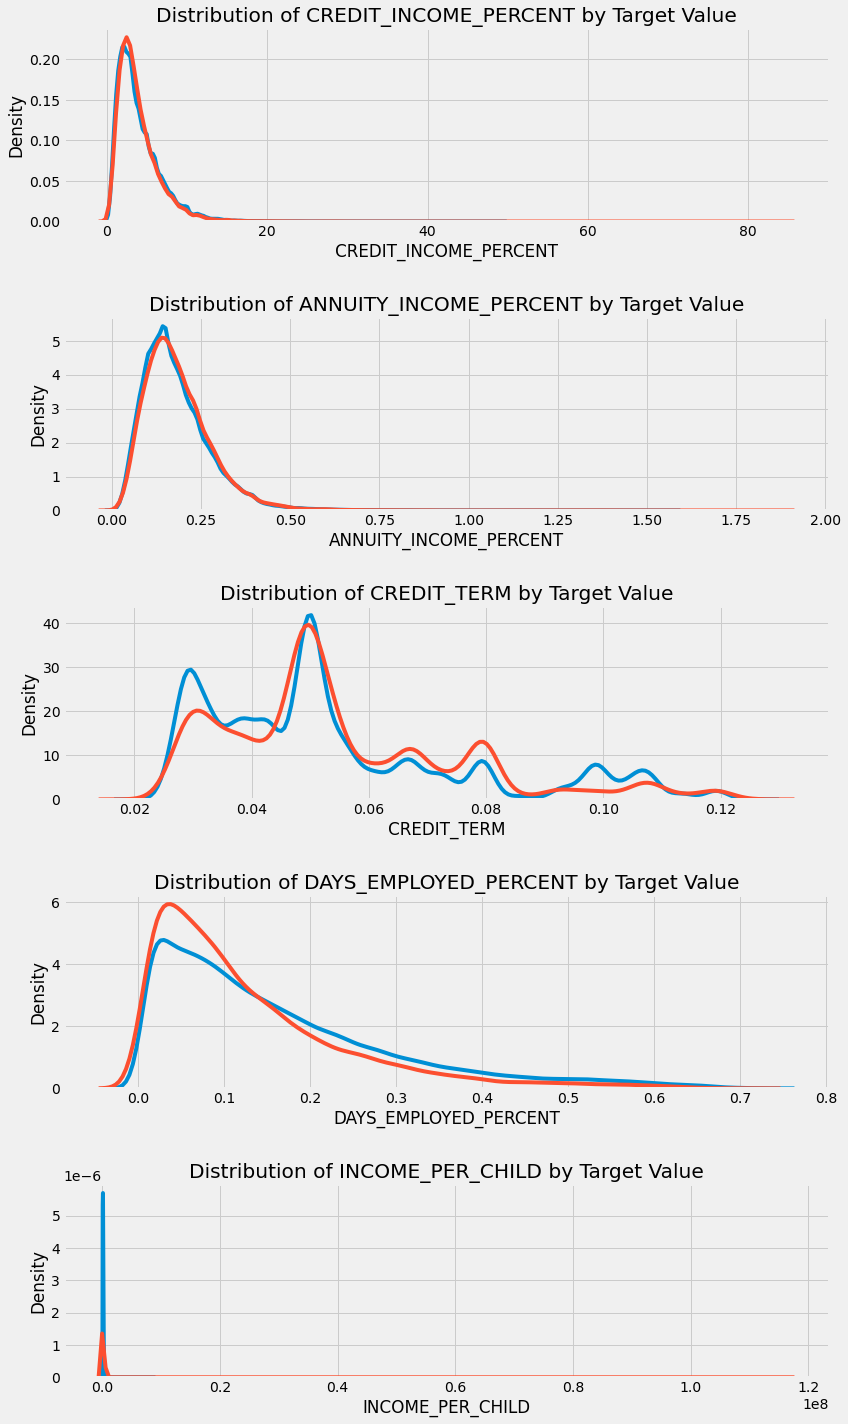

In [65]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT','INCOME_PER_CHILD']):
    
    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [66]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train_domain[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train_domain[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

再来看一下通过缺失值设计的这个特征，通过下图我们可以看到，缺失房屋信息的用户违约概率要明显高于未缺失用户，这在我们模型的预测中可以算是一个比较有效的特征了

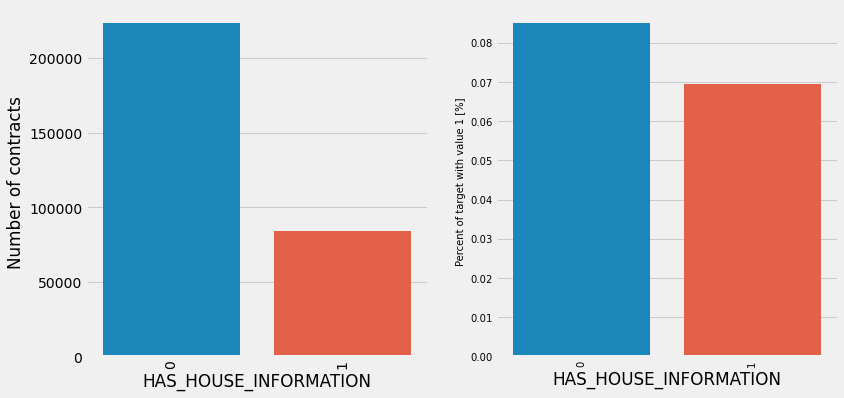

In [67]:
plot_stats('HAS_HOUSE_INFORMATION',True)

对测试集做同样的处理

In [68]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
app_test_domain['INCOME_PER_CHILD'] = app_test_domain['AMT_INCOME_TOTAL'] / app_test_domain['CNT_CHILDREN']
app_test_domain['HAS_HOUSE_INFORMATION'] = app_test_domain['COMMONAREA_MEDI'].apply(lambda x:1 if x>0 else 0)

## 建模预测

In [69]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

In [70]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    
    #Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [71]:
submission, fi, metrics = model(app_train_domain, app_test_domain)
print('Baseline metrics')
print(metrics)

del app_train_domain,app_test_domain
gc.collect

Training Data Shape:  (307511, 247)
Testing Data Shape:  (48744, 247)
[200]	train's auc: 0.804421	train's binary_logloss: 0.541832	valid's auc: 0.76227	valid's binary_logloss: 0.557669
[400]	train's auc: 0.833921	train's binary_logloss: 0.511411	valid's auc: 0.763074	valid's binary_logloss: 0.539011
[200]	train's auc: 0.804375	train's binary_logloss: 0.541874	valid's auc: 0.766396	valid's binary_logloss: 0.557693
[200]	train's auc: 0.803717	train's binary_logloss: 0.542765	valid's auc: 0.769687	valid's binary_logloss: 0.558004
[200]	train's auc: 0.804728	train's binary_logloss: 0.541835	valid's auc: 0.765429	valid's binary_logloss: 0.555999
[200]	train's auc: 0.804563	train's binary_logloss: 0.54162	valid's auc: 0.765072	valid's binary_logloss: 0.558914
Baseline metrics
      fold     train     valid
0        0  0.836218  0.763194
1        1  0.812209  0.766563
2        2  0.808762  0.769938
3        3  0.821007  0.765922
4        4  0.810617  0.765252
5  overall  0.817763  0.766133


<function gc.collect(generation=2)>

通过lgb自带的函数查看特征的重要性

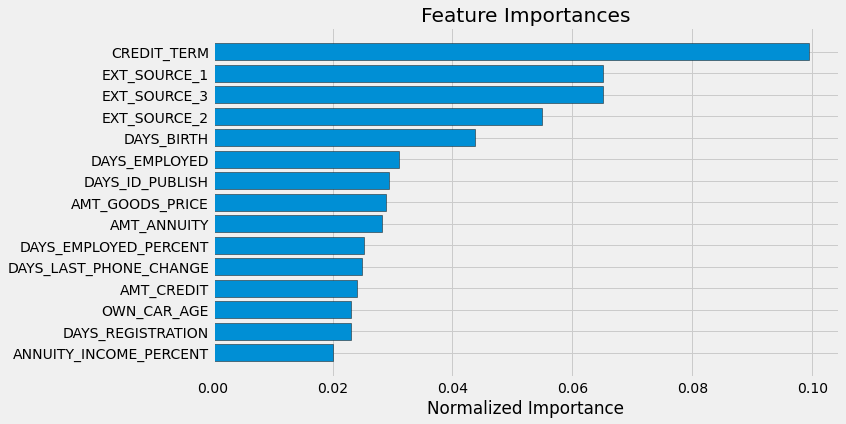

In [72]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
fi_sorted = plot_feature_importances(fi)


- 可知，Credit_term、ext_soruce、days_birth为在预测贷款违约当中最为重要的几个特性
- 特别是，在特征工程中建立的credit_term起到了很大的作用